# 1.环境准备

## 1.1 安装 PyTorch 和相关依赖

(1) 安装 PyTorch

In [2]:
# 根据你的环境选择 PyTorch 版本
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


(2) 安装其他依赖

In [3]:
# 安装音频处理库
!pip install numpy scipy librosa torchaudio

Looking in indexes: http://172.16.2.230:8501/simple/


In [4]:
# 安装评估工具
!pip install mir_eval

Looking in indexes: http://172.16.2.230:8501/simple/


## 1.2 检查 GPU/CPU 可用情况
安装完成后，运行以下 Python 代码，确认 PyTorch 是否正确安装，并检查 GPU 是否可用：

In [5]:
import torch

# 检查 PyTorch 版本
print("PyTorch 版本:", torch.__version__)

# 检查 GPU 是否可用
if torch.cuda.is_available():
    print("✅ GPU 可用！")
    print("GPU 数量:", torch.cuda.device_count())
    print("当前 GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ 没有检测到 GPU，使用 CPU 运行。")

# 检查 MPS (适用于 Mac M1/M2)
if torch.backends.mps.is_available():
    print("✅ MPS 可用！（Mac M1/M2 加速）")

PyTorch 版本: 2.6.0+cu124
✅ GPU 可用！
GPU 数量: 1
当前 GPU: NVIDIA GeForce GTX 1080


## 1.3 解决可能的问题
如果你的 GPU 驱动和 CUDA 版本不匹配，可以检查 CUDA 版本：

In [6]:
!nvidia-smi

Sun Mar 16 16:24:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080        Off |   00000000:02:00.0  On |                  N/A |
| 35%   44C    P8              6W /  180W |     427MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. 数据加载

## 2.1 数据集结构回顾
你的数据集在：

```swift
/home/easyai/DualDomain-SpeechSeparation/LibriMix-master/storage_dir/Libri2Mix/wav8k/min/train-360/
```
里面应该包含：

```bash
train-360/
├── mix_clean/   # 混合语音
├── s1/          # 目标说话人 1
├── s2/          # 目标说话人 2
├── noise/       # (如果包含噪声)
└── metadata/    # 数据集信息
```

## 2.2 创建 PyTorch Dataset
我们需要读取 混合语音（mix_clean）和 对应的说话人语音（s1、s2）。

In [7]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os

class LibriMixDataset(Dataset):
    def __init__(self, data_root):
        """
        初始化 LibriMix 数据集
        """
        self.data_root = data_root
        mix_files = set(os.listdir(os.path.join(data_root, "mix_clean")))
        s1_files = set(os.listdir(os.path.join(data_root, "s1")))
        s2_files = set(os.listdir(os.path.join(data_root, "s2")))

        # 取交集,确保文件一致
        common_files = sorted(list(mix_files & s1_files & s2_files))

        self.mix_files = common_files
        self.s1_files = common_files
        self.s2_files = common_files

        print(f"对齐后文件数: {len(self.mix_files)}")

    def __len__(self):
        return len(self.mix_files)

    def __getitem__(self, idx):
        """
        读取单个数据样本：
        - 混合语音 mix
        - 目标语音 s1 和 s2
        """
        mix_path = os.path.join(self.data_root, "mix_clean", self.mix_files[idx])
        s1_path = os.path.join(self.data_root, "s1", self.s1_files[idx])
        s2_path = os.path.join(self.data_root, "s2", self.s2_files[idx])
    
        # 读取音频
        mix_wav, sr = torchaudio.load(mix_path)
        s1_wav, _ = torchaudio.load(s1_path)
        s2_wav, _ = torchaudio.load(s2_path)

        # 确保所有音频是单通道
        mix_wav = mix_wav.mean(dim=0, keepdim=True) if mix_wav.shape[0] > 1 else mix_wav
        s1_wav = s1_wav.mean(dim=0, keepdim=True) if s1_wav.shape[0] > 1 else s1_wav
        s2_wav = s2_wav.mean(dim=0, keepdim=True) if s2_wav.shape[0] > 1 else s2_wav

        return mix_wav, s1_wav, s2_wav, sr

def collate_fn(batch):
    """
    处理变长的音频数据，进行填充（Padding）
    """
    mix, s1, s2, sr = zip(*batch)

    # 确保所有音频都是 (1, length) 形状
    mix = [x if x.dim() == 2 else x.unsqueeze(0) for x in mix]
    s1 = [x if x.dim() == 2 else x.unsqueeze(0) for x in s1]
    s2 = [x if x.dim() == 2 else x.unsqueeze(0) for x in s2]

    # 找到最长的音频长度
    max_len = max(x.shape[1] for x in mix)

    # 填充音频，使它们长度对齐
    def pad_audio(wav, target_len):
        pad_size = target_len - wav.shape[1]
        return torch.nn.functional.pad(wav, (0, pad_size))

    mix = torch.stack([pad_audio(x, max_len) for x in mix])
    s1 = torch.stack([pad_audio(x, max_len) for x in s1])
    s2 = torch.stack([pad_audio(x, max_len) for x in s2])

    return mix, s1, s2, sr

# 设置数据集路径
data_root = "train-360"
dataset = LibriMixDataset(data_root)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# 读取一个批次
#for mix, s1, s2, sr in dataloader:
#    print(f"采样率: {sr}")
#    print(f"混合音频形状: {mix.shape}")  # 形状应为 (batch_size, 1, max_samples)


对齐后文件数: 50800


## 2.3 测试数据加载
运行以下代码，检查数据是否正确加载：

In [8]:
# 读取一个批次
for mix, s1, s2, sr in dataloader:
    print(f"采样率: {sr}")
    print(f"混合音频形状: {mix.shape}")  # 形状应为 (batch_size, 1, samples)
    print(f"目标音频 1 形状: {s1.shape}")
    print(f"目标音频 2 形状: {s2.shape}")
    break

采样率: (8000, 8000, 8000, 8000)
混合音频形状: torch.Size([4, 1, 108080])
目标音频 1 形状: torch.Size([4, 1, 108080])
目标音频 2 形状: torch.Size([4, 1, 108080])


# 3. 模型实现（Dual-Domain Joint Encoder）
在这个步骤，我们将完成： ✅ 时域编码器

✅ 频域转换（STFT）

✅ 频域编码器

✅ 双域特征融合

✅ 分离掩码预测

✅ 反频域变换（ISTFT）

✅ 完整模型封装

## 3.1 模型结构
整个 Dual-Domain Joint Encoder 语音分离模型的结构如下：

1.时域编码器：使用 1D 卷积 处理原始语音。

2.频域转换（STFT）：将音频信号转换到频域，提取 频谱特征。

3.频域编码器：对频谱特征进行编码。

4.双域特征融合：将 时域 + 频域特征 结合，提高分离效果。

5.掩码预测：预测 分离掩码，用于恢复目标语音。

6.反频域变换（ISTFT）：将分离的频域信号转换回时域，生成最终的语音输出。

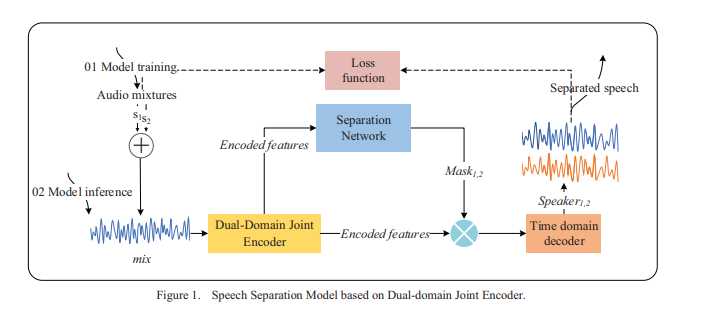

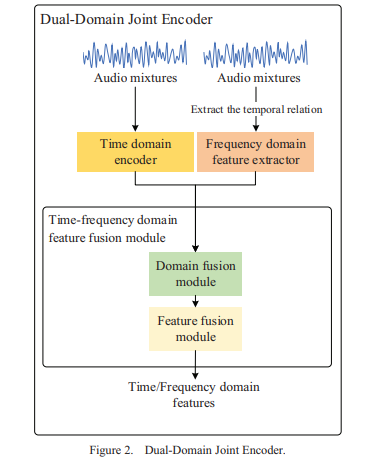

## 3.2 代码实现

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

class DualDomainJointEncoder(nn.Module):
    def __init__(self, encoder_dim=256, n_fft=512, hop_length=256, num_sources=2):
        super(DualDomainJointEncoder, self).__init__()
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_sources = num_sources

        # ===== 时域分支：Conv-TasNet 风格 =====
        # Conv-TasNet 的 encoder：无偏置卷积，学习基函数
        self.time_encoder = nn.Conv1d(1, encoder_dim, kernel_size=16, stride=8, bias=False)
        # 对应的 decoder：转置卷积，用于将潜在表示重构回时域
        self.time_decoder = nn.ConvTranspose1d(encoder_dim, 1, kernel_size=16, stride=8, bias=False)

        # ===== 频域分支 =====
        # 频域特征提取（STFT 后的幅度谱）
        self.freq_encoder = nn.Conv1d(n_fft // 2 + 1, encoder_dim, kernel_size=3, padding=1)

        # ===== 时频融合模块 =====
        self.domain_fusion = nn.Sequential(
            nn.Conv1d(encoder_dim * 2, encoder_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv1d(encoder_dim, encoder_dim, kernel_size=1)
        )

        # ===== 分离网络 =====
        self.separation_net = nn.Sequential(
            nn.Conv1d(encoder_dim, encoder_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(encoder_dim, encoder_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # ===== 掩码预测 =====
        # 在潜在域上预测每个源的掩码，输出通道数为 num_sources * encoder_dim
        self.mask_predictor = nn.Conv1d(encoder_dim, num_sources * encoder_dim, kernel_size=1)

    def forward(self, waveform):
        """
        输入:
         - waveform: (B, 1, samples) - 原始混合语音

        输出:
         - separated_speech: (B, num_sources, samples) - 分离后的语音
        """
        # ---- 时域编码（Conv-TasNet Encoder）----
        # 输出形状: (B, encoder_dim, time_steps)
        time_feat = F.relu(self.time_encoder(waveform))

        # ---- 频域分支 ----
        # 计算 STFT: 得到形状 (B, freq_bins, time_steps) 的复数张量
        spec = torch.stft(waveform.squeeze(1), n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True)
        # 取幅度谱，并添加通道维度: (B, 1, freq_bins, time_steps)
        spec_mag = spec.abs().unsqueeze(1)
        # 频域特征提取: (B, encoder_dim, time_steps)
        freq_feat = F.relu(self.freq_encoder(spec_mag.squeeze(1)))

        # ---- 保证时域和频域特征在时间维度上对齐 ----
        target_time_steps = freq_feat.shape[2]
        time_feat = F.interpolate(time_feat, size=target_time_steps, mode="nearest")

        # ---- 时频融合 ----
        # 拼接时域和频域特征: (B, 2*encoder_dim, time_steps)
        combined_feat = torch.cat([time_feat, freq_feat], dim=1)
        fused_feat = self.domain_fusion(combined_feat)  # (B, encoder_dim, time_steps)

        # ---- 分离网络 ----
        separated_feat = self.separation_net(fused_feat)  # (B, encoder_dim, time_steps)

        # ---- 掩码预测 ----
        # 输出形状: (B, num_sources*encoder_dim, time_steps)
        masks = self.mask_predictor(separated_feat)
        # 重塑为 (B, num_sources, encoder_dim, time_steps)
        B, _, T = masks.shape
        masks = masks.view(B, self.num_sources, -1, T)
        masks = torch.sigmoid(masks)

        # ---- 在潜在域上应用掩码 ----
        # 扩展时域编码特征形状: (B, 1, encoder_dim, time_steps)
        time_feat = time_feat.unsqueeze(1)
        # 应用掩码: (B, num_sources, encoder_dim, time_steps)
        masked_time_feat = masks * time_feat

        # ---- 利用 Conv-TasNet Decoder 重构时域语音 ----
        # 合并 batch 和 source 维度: (B*num_sources, encoder_dim, time_steps)
        B, num_sources, encoder_dim, T = masked_time_feat.shape
        masked_time_feat = masked_time_feat.reshape(B * num_sources, encoder_dim, T)
        # 重构：输出形状 (B*num_sources, 1, samples)
        reconstructed = self.time_decoder(masked_time_feat)
        
         # ---- 插值调整输出长度与原始波形一致 ----
        target_length = waveform.shape[-1]
        reconstructed = F.interpolate(reconstructed, size=target_length, mode='linear', align_corners=False)

        # 重塑回 (B, num_sources, samples)
        separated_speech = reconstructed.reshape(B, num_sources, target_length)

        return separated_speech


## 3.3 测试模型
在训练之前，我们先测试一下模型的输出是否正确：

In [10]:
# 测试输入
batch_size = 4
sample_length = 32000  # 假设 4 秒的音频，采样率 8kHz
test_input = torch.randn(batch_size, 1, sample_length)  # (batch, 1, samples)

# 初始化模型
model = DualDomainJointEncoder()

# 前向传播
output = model(test_input)

# 打印输出信息
print(f"输入形状: {test_input.shape}") 
print(f"输出形状: {output.shape}")    

输入形状: torch.Size([4, 1, 32000])
输出形状: torch.Size([4, 2, 32000])


/opt/anaconda3/lib/python3.12/site-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


# 4.训练流程
在这个步骤，我们将完成： ✅ 定义损失函数（SI-SNR）

✅ 构建优化器

✅ 训练循环（数据输入 → 前向传播 → 计算损失 → 反向传播 → 更新参数）

✅ 保存模型

## 4.1 定义损失函数
在语音分离任务中，常用的损失函数是：

SI-SNR（Scale-Invariant Signal-to-Noise Ratio）：尺度不变信噪比

PIT（Permutation Invariant Training）：用于解决说话人顺序不确定性问题

In [11]:
def si_snr_loss(est_source, target_source, eps=1e-8):
    """
    计算 SI-SNR 损失
    :param est_source: 估计的语音信号 (batch, 1, samples)
    :param target_source: 真实的语音信号 (batch, 1, samples)
    :return: SI-SNR 损失
    """
    # 计算投影
    target = torch.sum(est_source * target_source, dim=-1, keepdim=True) * target_source / \
             (torch.sum(target_source**2, dim=-1, keepdim=True) + eps)

    # 计算误差信号
    noise = est_source - target

    # 计算信噪比
    ratio = torch.sum(target**2, dim=-1) / (torch.sum(noise**2, dim=-1) + eps)

    # 转换为 dB
    si_snr = 10 * torch.log10(ratio + eps)

    return -si_snr.mean()


In [12]:
def pit_loss(est_sources, target_sources):
    """
    计算 PIT（Permutation Invariant Training）损失
    :param est_sources: 估计的语音信号 (batch, 2, samples)
    :param target_sources: 真实的语音信号 (batch, 2, samples)
    :return: 最优排列的 SI-SNR 损失
    """
    loss_1 = (si_snr_loss(est_sources[:, 0, :], target_sources[:, 0, :]) + \
             si_snr_loss(est_sources[:, 1, :], target_sources[:, 1, :])) / 2
    
    loss_2 = (si_snr_loss(est_sources[:, 0, :], target_sources[:, 1, :]) + \
             si_snr_loss(est_sources[:, 1, :], target_sources[:, 0, :])) / 2

    return torch.min(loss_1, loss_2)

## 4.2 训练循环

In [ ]:
import torch.optim as optim

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
model = DualDomainJointEncoder().to(device)

# 选择优化器
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# 训练参数
epochs = 10
train_loss_history = []

# 训练循环
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for mix, target1, target2, sr in dataloader:
        # 发送数据到 GPU
        mix, target1, target2 = mix.to(device), target1.to(device), target2.to(device)

        # 预测
        output = model(mix)  # (batch, 2, samples)

        # 组合真实语音
        target_sources = torch.stack([target1.squeeze(1), target2.squeeze(1)], dim=1)  # (batch, 2, samples)

        # 计算损失 (使用 PIT)
        loss = pit_loss(output, target_sources)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    train_loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # 每 2 轮保存一次模型
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f"dual_domain_epoch{epoch+1}.pth")
        print(f"✅ 模型已保存: dual_domain_epoch{epoch+1}.pth")

Epoch [1/10], Loss: 47.3992


## 4.3 训练结果可视化
使用 matplotlib 绘制损失曲线：

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs+1), train_loss_history, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid()
plt.show()

## 4.4 训练后的模型保存

In [ ]:
# 手动保存整个模型：
torch.save(model.state_dict(), "dual_domain_final.pth")
print("✅ 最终模型已保存: dual_domain_final.pth")

In [ ]:
# 保存整个模型结构
torch.save(model, "dual_domain_model.pth")

# 5. 模型评估
在这个步骤，我们将完成： 

✅ 计算 SI-SNR（尺度不变信噪比）

✅ 计算 SDR（信号失真比）

✅ 评估测试数据上的分离性能

✅ 可视化训练结果

## 5.1 计算 SI-SNR（尺度不变信噪比）
在语音分离任务中，SI-SNR（Scale-Invariant Signal-to-Noise Ratio） 是评估语音质量的核心指标。它衡量的是预测音频和目标音频的相似程度，值越高，分离质量越好。

In [ ]:
def si_snr(est_source, target_source, eps=1e-8):
    """
    计算 SI-SNR（尺度不变信噪比）
    :param est_source: 估计的语音信号 (batch, 1, samples)
    :param target_source: 真实的语音信号 (batch, 1, samples)
    :return: SI-SNR 分数
    """
    # 计算投影
    target = torch.sum(est_source * target_source, dim=-1, keepdim=True) * target_source / \
             (torch.sum(target_source**2, dim=-1, keepdim=True) + eps)

    # 计算误差信号
    noise = est_source - target

    # 计算信噪比
    ratio = torch.sum(target**2, dim=-1) / (torch.sum(noise**2, dim=-1) + eps)

    # 转换为 dB
    si_snr_value = 10 * torch.log10(ratio + eps)

    return si_snr_value.mean().item()

## 5.2 计算 SDR（信号失真比）
SDR（Signal-to-Distortion Ratio）用于衡量信号的失真程度。可以使用 mir_eval 进行计算：

In [ ]:
from mir_eval.separation import bss_eval_sources
import numpy as np

def eval_sdr(pred, target):
    """
    计算 SDR（信号失真比）
    :param pred: 预测语音信号 (batch, samples)
    :param target: 真实语音信号 (batch, samples)
    :return: SDR 分数
    """
    pred, target = pred.cpu().numpy(), target.cpu().numpy()
    sdr, _, _, _ = bss_eval_sources(target, pred)
    return sdr.mean()

## 5.3 评估测试集
我们使用 测试数据集（test-360） 进行评估，计算 SI-SNR 和 SDR。

In [ ]:
# 加载测试集
test_root = "test/"
test_dataset = LibriMixDataset(test_root)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# 加载训练好的模型
model = DualDomainJointEncoder().to(device)
model.load_state_dict(torch.load("dual_domain_final.pth"))
model.eval()

# 评估
si_snr_scores = []
sdr_scores = []

with torch.no_grad():
    for mix, target1, target2, sr in test_dataloader:
        mix, target1, target2 = mix.to(device), target1.to(device), target2.to(device)

        # 预测分离语音
        output = model(mix)  # (batch, 2, samples)

        # 计算 SI-SNR
        si_snr_1 = si_snr(output[:, 0, :], target1)
        si_snr_2 = si_snr(output[:, 1, :], target2)
        avg_si_snr = (si_snr_1 + si_snr_2) / 2
        si_snr_scores.append(avg_si_snr)

        # 计算 SDR
        sdr_1 = eval_sdr(output[:, 0, :].squeeze(), target1.squeeze())
        sdr_2 = eval_sdr(output[:, 1, :].squeeze(), target2.squeeze())
        avg_sdr = (sdr_1 + sdr_2) / 2
        sdr_scores.append(avg_sdr)

        print(f"SI-SNR: {avg_si_snr:.2f}, SDR: {avg_sdr:.2f}")

# 计算平均值
mean_si_snr = np.mean(si_snr_scores)
mean_sdr = np.mean(sdr_scores)

print(f"✅ 测试集平均 SI-SNR: {mean_si_snr:.2f} dB")
print(f"✅ 测试集平均 SDR: {mean_sdr:.2f} dB")


## 5.4 结果可视化
我们绘制 SI-SNR 和 SDR 的分布：

In [ ]:
import matplotlib.pyplot as plt

# 绘制 SI-SNR 分布
plt.figure(figsize=(10, 5))
plt.hist(si_snr_scores, bins=20, alpha=0.7, label="SI-SNR")
plt.axvline(mean_si_snr, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_si_snr:.2f} dB")
plt.xlabel("SI-SNR (dB)")
plt.ylabel("Count")
plt.title("SI-SNR Distribution on Test Set")
plt.legend()
plt.show()

# 绘制 SDR 分布
plt.figure(figsize=(10, 5))
plt.hist(sdr_scores, bins=20, alpha=0.7, label="SDR")
plt.axvline(mean_sdr, color='r', linestyle='dashed', linewidth=2, label=f"Mean: {mean_sdr:.2f} dB")
plt.xlabel("SDR (dB)")
plt.ylabel("Count")
plt.title("SDR Distribution on Test Set")
plt.legend()
plt.show()

# 6. 推理测试 (可选)
在这个步骤，我们将完成： 

✅ 加载训练好的模型

✅ 输入新的混合语音，进行语音分离

✅ 保存 & 播放分离后的音频

## 6.1 加载训练好的模型

In [ ]:
import torchaudio

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
model = DualDomainJointEncoder().to(device)
model.load_state_dict(torch.load("dual_domain_final.pth"))
model.eval()

print("✅ 模型加载完成！")

## 6.2 读取测试音频
从 LibriMix 测试集选择一个混合音频：

In [ ]:
import os

# 选择测试集中的一个音频样本
test_audio_path = "test/mix_clean/00001.wav"

# 读取音频
waveform, sr = torchaudio.load(test_audio_path)
waveform = waveform.to(device)

print(f"✅ 加载测试音频: 采样率 {sr}, 形状 {waveform.shape}")

## 6.3 语音分离

In [ ]:
with torch.no_grad():
    output = model(waveform.unsqueeze(0))  # (1, 2, samples)
    separated_speech = output.squeeze(0)  # (2, samples)

# 获取分离后的两个语音
speech_1 = separated_speech[0, :].cpu()
speech_2 = separated_speech[1, :].cpu()

print("✅ 语音分离完成！")


## 6.4 保存分离后的音频

In [ ]:
# 创建保存路径
output_dir = "output_audio"
os.makedirs(output_dir, exist_ok=True)

# 保存音频
torchaudio.save(os.path.join(output_dir, "speech_1.wav"), speech_1.unsqueeze(0), sr)
torchaudio.save(os.path.join(output_dir, "speech_2.wav"), speech_2.unsqueeze(0), sr)

print("✅ 分离后的音频已保存！")

## 6.5 播放音频
在 Python 代码中，我们可以使用 IPython.display.Audio 来播放音频：

In [ ]:
from IPython.display import Audio

print("🎧 原始混合音频：")
Audio(test_audio_path)

print("🎧 分离出的语音 1：")
Audio(os.path.join(output_dir, "speech_1.wav"))

print("🎧 分离出的语音 2：")
Audio(os.path.join(output_dir, "speech_2.wav"))

# 7. 结果分析(可选)
在这个步骤，我们将完成： 

✅ 绘制波形对比图（原始混合语音 vs. 分离语音）

✅ 计算分离效果指标（SDR、SI-SNR）

✅ 分析分离质量和可能的改进点

## 7.1 可视化波形
我们将绘制：

混合语音（输入）

目标语音（Ground Truth）

分离出的语音（模型输出）


🎯 目标：

对比输入混合语音和分离语音的波形

查看分离出的语音是否匹配目标语音

In [ ]:
import matplotlib.pyplot as plt

# 读取原始目标语音
target1_path = "test/s1/00001.wav"
target2_path = "test/s2/00001.wav"

target1, _ = torchaudio.load(target1_path)
target2, _ = torchaudio.load(target2_path)

# 画波形图
fig, axs = plt.subplots(4, 1, figsize=(12, 8))

# 原始混合语音
axs[0].plot(waveform.cpu().squeeze().numpy(), label="Mixed Speech", color="black")
axs[0].set_title("Mixed Speech (Input)")
axs[0].legend()

# 目标语音 1
axs[1].plot(target1.cpu().squeeze().numpy(), label="Target Speaker 1", color="blue")
axs[1].set_title("Target Speaker 1 (Ground Truth)")
axs[1].legend()

# 目标语音 2
axs[2].plot(target2.cpu().squeeze().numpy(), label="Target Speaker 2", color="red")
axs[2].set_title("Target Speaker 2 (Ground Truth)")
axs[2].legend()

# 分离出的语音
axs[3].plot(speech_1.numpy(), label="Predicted Speaker 1", color="blue", linestyle="dashed")
axs[3].plot(speech_2.numpy(), label="Predicted Speaker 2", color="red", linestyle="dashed")
axs[3].set_title("Separated Speech (Model Output)")
axs[3].legend()

plt.tight_layout()
plt.show()

## 7.2 计算分离质量
我们用 SI-SNR 和 SDR 评估分离质量：

In [ ]:
# 计算 SI-SNR
si_snr_1 = si_snr(speech_1.unsqueeze(0), target1)
si_snr_2 = si_snr(speech_2.unsqueeze(0), target2)
print(f"✅ 分离后 SI-SNR: Speaker 1: {si_snr_1:.2f} dB, Speaker 2: {si_snr_2:.2f} dB")

# 计算 SDR
sdr_1 = eval_sdr(speech_1.unsqueeze(0), target1)
sdr_2 = eval_sdr(speech_2.unsqueeze(0), target2)
print(f"✅ 分离后 SDR: Speaker 1: {sdr_1:.2f} dB, Speaker 2: {sdr_2:.2f} dB")


🎯 目标：

检查 SI-SNR 是否提高

查看 SDR 评分是否合理

✅ 参考标准（WSJ0-2mix 语音分离任务）：

SI-SNR > 10dB 表示分离质量较好

SDR > 10dB 说明信号失真较低